In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Simulating stochastic population dynamics

### Erol Akcay
Department of Biology, University of Pennsylvania

Bio 417 Spring 2019 

### Continuous time case

We will construct a stochastic simulation for the birth-death process in continuous time, both to check our analytical solutions (always good to do) and also to illustrate the principles of constructing stochastic simulations. 

We will first consider the birth-death process with constant $b$ and $d$ first (the algorithm can easily be extended to when $b_n$ and $d_n$ depend on the population size). Given time-invariant rates $b$ and $d$, the time until the next birth *or* death event is exponentially distributed, with rate $b+d$, i.e., the probability density of t is given by:
$$
P(t)=(b+d) e^{-(b+d)t}
$$
We can use numpy's random number generator to generate a waiting time until the next time step:

In [2]:
np.random.exponential(1/0.3) 
#here, 1/0.3 is the rate of the exponential, 
#the function takes the "scale" of the exponential, 
#which is the inverse of the rate, as asgument

2.2816170006238874

Or we can generate a whole lot of waiting times at once (which tends to be computationally more efficient)

In [3]:
waits=np.random.exponential(1/.3, 10000) #here, 1/0.3 is the rate of the exponential, 
#and we asked numpy to draw 10000 pseudorandom numbers 

Now, this is the waiting times between birth *or* death events. Given that one of the events has happened, the probability it's a birth is given by $\frac{b}{b+d}$ and that it is a death is $\frac{d}{b+d}$. So, for a single individual, the probability that it will experience a birth at time t from now is given by:
$$
P(t, birth)=(b+d)e^{-(b+d)t}\frac{b}{b+d}=b e^{-(b+d)t}
$$

So, our "naive" algorithm will run something like this:
 1. Set the population size at $n=n_0$ to initialize.
 2. Draw a waiting time form an exponential distribution with rate $(b+d)n$
 3. Draw a Bernoulli random variable with probability $\frac{b}{b+d}$.
 4. If the Bernoulli variable is 1, set n=n+1, if not, set n=n-1. 
 5. Go to step 2.
 
This is the direct implementation of a well-known algorithm called the Gillespie Algorithm

In [4]:
def gillespie(b,d,n0,tmax):
    times=list([]) #make list for times, keep it empty.
    popsize=list([]) #make list for pop size, keep it empty
    wait=0
    pop=n0
    while wait < tmax and pop > 0:
        times.append(wait) #add the current event's time to the times list
        popsize.append(pop) #add the current population size to the population history
        wait=times[-1]+np.random.exponential(1/(pop*(b+d))) #draw a wait time and add it to time of last event.
        pop=pop-1+2*np.random.binomial(1,b/(b+d)) #choose birth or death, increment or decrement population size accordingly
    return times, popsize

Now we are ready to run the population. The output of the function gillespie is two lists, one giving the timing of births and deaths, and the other the population size at each recorded time.

In [5]:
gillespie(.3,.2,4,5)

([0,
  0.38108637946407903,
  2.3909121762214656,
  2.937633225112918,
  2.988939569040833,
  3.0076284633071637,
  3.1355507089183745,
  3.163333253590328,
  3.3700683349970264,
  3.428747122554664,
  4.902612951836734],
 [4, 3, 4, 5, 6, 7, 6, 7, 8, 9, 10])

We can plot one realization of the stochastic population dynamics as follows: below, the initial population size is set at 10, and birth rate 0.35, death rate 0.35, and maximum time 10. Each time you run the cell below, you will get a different realization (b/c python will draw a new set of pseudorandom numbers)

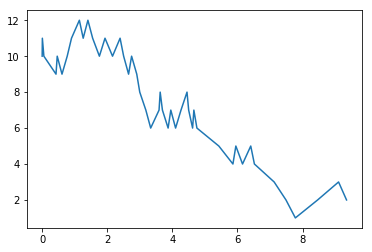

In [39]:
times, population = gillespie(.35,.35,10,10)
plt.plot(times, population)

Now you can do the same for, say, 100 times, and plot all the trajectories. This is called an ensemble of trajectories (or populations). Basically all the probabilitic statements we derived analytically apply to very large ensembles of populations.

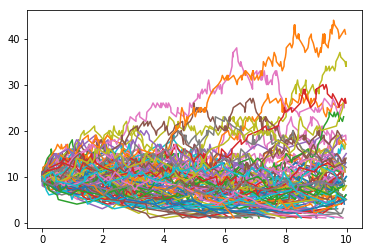

In [40]:
for i in range(100):
    times, population = gillespie(.35,.35,10,10)
    plt.plot(times, population)

You can look at the distribution of the population sizes at time 10:

In [142]:
endpop=list([])
for i in range(10000):
    times, population = gillespie(.1,.1,100,10)
    endpop.append(population[-1])

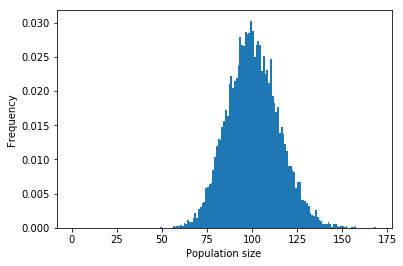

In [143]:
plt.hist(endpop,density=True,bins=range(0,max(endpop)+1,1)) #plots the histogram, with bins sizes of 1
plt.xlabel('Population size')
plt.ylabel('Frequency')
plt.show()

From these simulations, one can estimate, say, the probability that the population is below 50 or above 150 at the end:

In [144]:
[(np.asarray(endpop) < 50).sum()/10000, (np.asarray(endpop) > 150).sum()/10000]

[0.0001, 0.0008]

Now, in principle, we can differentiate the probability generating function we found analytically in the class (lecture notes, equation 23) n times and evaluate it at z=0, and get the expected probability distribution and compare it with the simulated one. 

For that, let's first import sympy, which contains the necessary functions for symbolic differentiation.

In [16]:
import sympy as sym

In [17]:
z = sym.symbols('z') # we need to tell sympy that z is a symbolic variable
tt = sym.symbols('tt')

Now we can define the probability generating function

In [114]:
def pgf(z,t,b,d,n0):
    return ((d*(1-z)*np.exp((b-d)*t)-(d-b*z))/(b*(1-z)*np.exp((b-d)*t)-(d-b*z)))**n0

Remember that we had to separate the case where b=d, so we define a separate function using the solution for that case:

In [115]:
def pgf1(z,t,b,n0):
    return ((b*t+(1-b*t)*z)/((1+b*t)-b*t*z))**n0

In [116]:
pgf1(0,5,.6,10)

0.056313514709472656

And a function that takes the nth derivative, divides by $n!$ and evaluates it at z=0, giving us $p_n$ 

In [123]:
1/np.math.factorial(3)*sym.diff(pgf1(z,10,.1,100),z,2).subs(z,0)

3.31978964280509e-28

In [124]:
def pneval(n,t,b,d,n0):
    if b==d:
        return 1/np.math.factorial(n)*sym.diff(pgf1(z,t,b,n0),z,n).subs(z,0)
        #return derivative.subs(z,0)
    else:
        return 1/np.math.factorial(n)*sym.diff(pgf(z,t,b,d,n0),z,n).subs(z,0)
        #return derivative.subs(z,0)

In [128]:
pneval(20,10,.35,.35,10)

0.0165144671204211

Evaluate the probabilities for n from 0 to 100

In [150]:
dist=[pneval(i,10,.1,.1,100) for i in range(0,200)]

In [151]:
np.sum(dist)

0.999998816895840

Text(0, 0.5, 'Frequency')

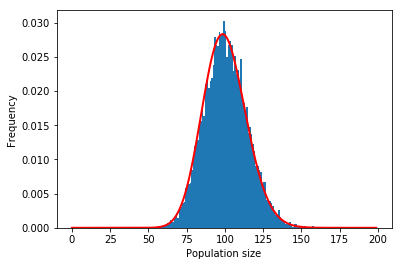

In [152]:
plt.hist(endpop,density=True,bins=range(0,max(endpop)+1,1)) #plots the histogram, with bins sizes of 1
plt.plot(dist,'r',linewidth=2.0)
plt.xlabel('Population size')
plt.ylabel('Frequency')

Pretty good fit, overall, which suggests both the simulation and the analytical method work.

### Discrete time case

Now let's do the discrete time Markov-chain model for the birth-death process. The birth and death rates will now be a function of the population size (but not time). In particular, I want to assume constant death probabilities $d$ in population size, but a linearly decreasing birth probability.
$$
b_n=b_0- a n
$$
for $n<b_0/a$; $b_n=0$ for $n\geq b_0/a$. The fact that $b_n=0$ for some finite $n$ means that the population can't go beyond that size if it starts below it (and will come below it if it starts above), and thus we can deal only with $0\leq n\leq b_0/a$. Again, $b_n$ and $d$ are now probabilities, not rates, so they are constrained to be between 0 and 1. 

Now let's write the transition matrix. We begin by defining the parameters: 

In [19]:
b0=.6
a=.6/20
d=.1

Next, we use list comprehension to generate a list of lists that is our matrix. Notice our use of the Kroenecker delta $\delta_{ij}$ (using the function sym.KroneckerDelta(i,j)), which is simply a shorthand notation for 1 when $i=j$ and 0 elsewhere. We use it to make only diagonal and the offdiagonal elements non-zero.

In [20]:
transition = [[sym.KroneckerDelta(i,j)*(1-(b0-a*i)-(1-sym.KroneckerDelta(0,i))*d)+sym.KroneckerDelta(i,j-1)*d+sym.KroneckerDelta(i,j+1)*(b0-a*(i-1)) for j in range(0,21,1)] for i in range(0,21,1)]

Next, we need to convert this list to a numpy array:

In [21]:
transarray=np.asarray(transition, dtype=np.float)

Now, we use numpy.linalg.eig function to get the eigenvalues and vectors

In [22]:
eigvals, eigvecs = np.linalg.eig(transarray)

This gets the eigenvector associated with the largest eigenvalue (you can check that the latter is 1), normalizes it so that its sum is equal to 1 (since that gives us the stationary distribution), and plots the resulting values. 

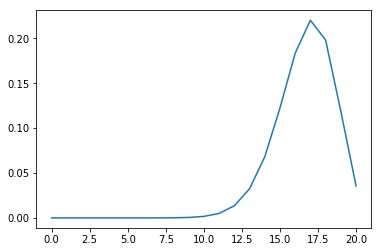

In [23]:
plt.plot(eigvecs[:, eigvals.argmax()]/np.sum(eigvecs[:, eigvals.argmax()]))

Now we can also write a function that iterates the transition matrix n times, starting from an initial population.

In [24]:
def transiterate(trans, init, nit):
    vec=init
    for i in range(nit):
        vec=np.dot(trans, vec)
    return vec

Initialize the population at size 10.

In [25]:
init = np.asarray([sym.KroneckerDelta(i,10) for i in range(0,21)], dtype=np.float32)

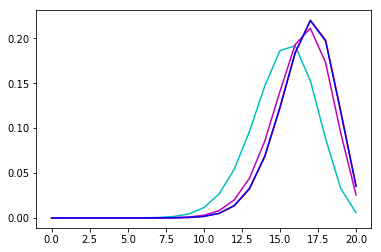

In [26]:
plt.plot(eigvecs[:, eigvals.argmax()]/np.sum(eigvecs[:, eigvals.argmax()]),'r')
plt.plot(transiterate(transarray,init,50),'c')
plt.plot(transiterate(transarray,init,100),'m')
plt.plot(transiterate(transarray,init,200),'b')

As you can see, after applying the matrix many times, the population converges to the stationary distribution. (The cyan plot is after 50 time-steps, the magenta after 100, and the blue after 200 time steps. The red plot, almost completely overlayed by the blue one, is the normalized eigenvector of the transition matrix).

In [27]:
stationary = eigvecs[:, eigvals.argmax()]/np.sum(eigvecs[:, eigvals.argmax()])

In [28]:
stationary.argmax()

17

The stationary distribution peaks at $n=17$. Not coincidentally, for our parameter values, the value of $n$ that makes $b_n-d=0$ is approximately 16.67. In a deterministic model, that would be the carrying capacity of the population. We thus see that the stochastic model basically fluctuates around the carrying capacity. 

Now we can also simulate individual population trajectories, similar to the continuous time case. In fact, it's easier to simulate the discrete time, since we don't have to keep track of times at which births and deaths occur (since time is discrete). The function below does the forward simulation.

In [29]:
def discretes(b0,a,d,n0,tmax):
    popsize=list([]) #make list for pop size, keep it empty
    pop=n0
    i=0
    while i <= tmax and pop >= 0:
        popsize.append(pop) #add the current population size to the population history
        bn=np.max([b0-a*pop,0])
        pop=pop+np.dot([1,-1,0],np.random.multinomial(1,[bn,d,1-bn-d])) #choose birth or death, increment or decrement population size accordingly
        i+=1
    return popsize

Here's a sample trajectory

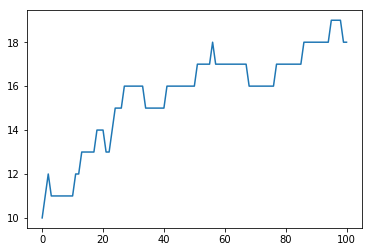

In [30]:
plt.plot(discretes(.6,.6/20,.1,10,100))

Here are 20 more:

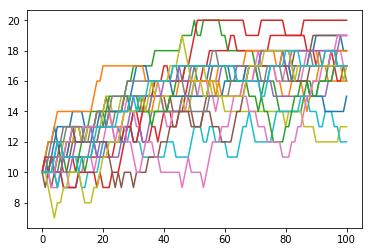

In [31]:
for i in range(20):
    plt.plot(discretes(.6,.6/20,.1,10,100))

In [32]:
discendpop=list([])
for i in range(1000):
    hists = discretes(.6,.6/20,.1,10,100)
    discendpop.append(hists[-1])

As can be seen from the plot below, our probability distribution after 100 iterations (starting from a population of size 10) gives a very good match to the distribution of simulated populations (starting with size 10) after 100 time steps. 

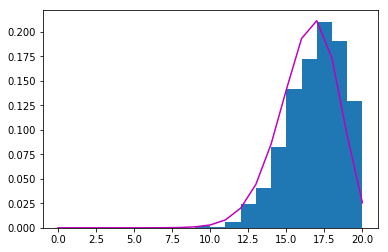

In [33]:
plt.hist(discendpop, normed=True, bins=range(0,max(discendpop)+1,1));
plt.plot(transiterate(transarray,init,100),'m')

In [34]:
discendpop=list([])
for i in range(1000):
    hists = discretes(.6,.6/20,.1,10,200)
    discendpop.append(hists[-1])

If we iterate even further, then our stationary distribution (the eigenvector associated with the leaving eigenvalue, which is equal to 1) predicts the distribution of the population in the long term. 

Graphics note: Note that in the below and above graphs the histogram appears shifted slightly to the left, since the bars are centered around the .5 point, whereas the plot of the stationary distribution takes integer values as the x coordinate. That's just a plotting nicety, one that you could get rid of if you wanted.

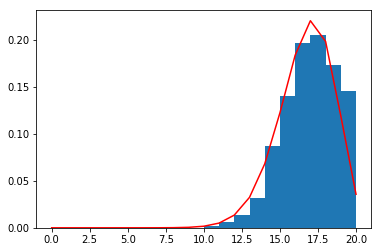

In [35]:
plt.hist(discendpop, normed=True, bins=range(0,max(discendpop)+1,1));
plt.plot(eigvecs[:, eigvals.argmax()]/np.sum(eigvecs[:, eigvals.argmax()]),'r')